ALBA Mª LAGUNA MORALEDA

RAÚL VALLVERDÚ ESTEBÁN

In [858]:
import findspark
findspark.init()
from pyspark import SparkConf 
from pyspark import SparkContext as sc
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import six
import seaborn as sns
sns.set(color_codes=True)
import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, SQLTransformer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col,sum

In [859]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

**<center><span style="font-family:Cooper Black; font-size:3em;color:darkblue">PROYECTO OPEN DATA II</span> </center>**

In [860]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [861]:
import pyspark.sql.types as typ
import pandas as pd

<span style="font-family:Comic Sans MS; font-size:14;color:black">Una vez creada la sesión de Spark, procedemos a crear nuestro Schema con las variables del dataset elegido y con el respectivo tipo de dato de cada una de las variables</span>


In [862]:
labels = [
    ('Education', typ.StringType()),
    ('JoiningYear', typ.IntegerType()),
    ('City', typ.StringType()),
    ('PaymentTier', typ.IntegerType()),
    ('Age', typ.IntegerType()),
    ('Gender', typ.StringType()),
    ('EverBenched', typ.StringType()),
    ('ExperienceInCurrentDomain', typ.StringType()),
    ('Leave', typ.StringType()),
]

schema = typ.StructType([
    typ.StructField(e[0], e[1], False) for e in labels
])


<span style="font-family:Comic Sans MS; font-size:14;color:black">Importamos y mostramos el dataset con el que posteriormente vamos a trabajar. Nuestra variable objetivo en este caso es Leave y es en este caso de clasificación binaria</span>


In [863]:
df=spark.read.schema(schema).options(delimiter=',', header='True').csv('Employee')
df.show()

+---------+-----------+---------+-----------+---+------+-----------+-------------------------+-----+
|Education|JoiningYear|     City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|Leave|
+---------+-----------+---------+-----------+---+------+-----------+-------------------------+-----+
|Bachelors|       2017|Bangalore|          3| 34|  Male|         No|                        0|    0|
|Bachelors|       2013|     Pune|          1| 28|Female|         No|                        3|    1|
|Bachelors|       2014|New Delhi|          3| 38|Female|         No|                        2|    0|
|  Masters|       2016|Bangalore|          3| 27|  Male|         No|                        5|    1|
|  Masters|       2017|     Pune|          3| 24|  Male|        Yes|                        2|    1|
|Bachelors|       2016|Bangalore|          3| 22|  Male|         No|                        0|    0|
|Bachelors|       2015|New Delhi|          3| 38|  Male|         No|                       

<span style="font-family:Comic Sans MS; font-size:14;color:black">Comprobamos que nuestro dataset se ha leído correctamente</span>


In [864]:
df.toPandas().head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Leave
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


<span style="font-family:Comic Sans MS; font-size:14;color:black">Comprobamos si hay algún valor nulo, que en nuestro caso como se puede ver no hay ninguno</span>



In [865]:
df_null = df.select(*(F.sum(F.col(c).isNull().cast('Integer')).alias(c) for c in df.columns)).toPandas()
df_null

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Leave
0,0,0,0,0,0,0,0,0,0


<span style="font-family:Comic Sans MS; font-size:14;color:black">A continuación, vemos que tipo de dato pertenece a cada variable para posteriormente adecuarlas todas a las necesidades del modelo</span>


In [866]:
df.dtypes

[('Education', 'string'),
 ('JoiningYear', 'int'),
 ('City', 'string'),
 ('PaymentTier', 'int'),
 ('Age', 'int'),
 ('Gender', 'string'),
 ('EverBenched', 'string'),
 ('ExperienceInCurrentDomain', 'string'),
 ('Leave', 'string')]

<span style="font-family:Comic Sans MS; font-size:14;color:black">En la siguiente celda lo que comprobamos es el numero total de datos que tiene nuestro dataset</span>


In [867]:
df.count()

4653

In [868]:
import pyspark.ml.feature as ft
import pyspark.sql.types as typ
import pandas as pd
from pyspark.ml.feature import StringIndexer

<span style="font-family:Comic Sans MS; font-size:14;color:black">Aplicamos el StringIndexer a las variables de tipo string de nuestro dataset </span>



In [869]:

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ['Gender','EverBenched','Education','ExperienceInCurrentDomain','Leave'] ]



<span style="font-family:Comic Sans MS; font-size:14;color:black">En la siguiente celda mostramos como a partir del stringindexer y el pipeline hemos cambiado las variables string a tipo numérico </span>


In [870]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=indexers)
df2 = pipeline.fit(df).transform(df)

df2.show() 

+---------+-----------+---------+-----------+---+------+-----------+-------------------------+-----+------------+-----------------+---------------+-------------------------------+-----------+
|Education|JoiningYear|     City|PaymentTier|Age|Gender|EverBenched|ExperienceInCurrentDomain|Leave|Gender_index|EverBenched_index|Education_index|ExperienceInCurrentDomain_index|Leave_index|
+---------+-----------+---------+-----------+---+------+-----------+-------------------------+-----+------------+-----------------+---------------+-------------------------------+-----------+
|Bachelors|       2017|Bangalore|          3| 34|  Male|         No|                        0|    0|         0.0|              0.0|            0.0|                            5.0|        0.0|
|Bachelors|       2013|     Pune|          1| 28|Female|         No|                        3|    1|         1.0|              0.0|            0.0|                            3.0|        1.0|
|Bachelors|       2014|New Delhi|       

<span style="font-family:Comic Sans MS; font-size:14;color:black">Procedemos a borrar las columnas que anteriormente estaban con el tipo de dato String y que ya hemos transformado </span>



In [871]:
df2 = df2.drop('Gender')
df2 = df2.drop('EverBenched')
df2 = df2.drop('Education')
df2= df2.drop('ExperienceInCurrentDomain')
df2= df2.drop('Leave')
df2.show()

+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+
|JoiningYear|     City|PaymentTier|Age|Gender_index|EverBenched_index|Education_index|ExperienceInCurrentDomain_index|Leave_index|
+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+
|       2017|Bangalore|          3| 34|         0.0|              0.0|            0.0|                            5.0|        0.0|
|       2013|     Pune|          1| 28|         1.0|              0.0|            0.0|                            3.0|        1.0|
|       2014|New Delhi|          3| 38|         1.0|              0.0|            0.0|                            0.0|        0.0|
|       2016|Bangalore|          3| 27|         0.0|              0.0|            1.0|                            2.0|        1.0|
|       2017|     Pune|          3| 24|         0.0|              1.0|            1

<span style="font-family:Comic Sans MS; font-size:14;color:black">Como se puede observar en la siguiente celda todos los datos que tenemos ahora son de tipo numérico</span>


In [872]:
df2.dtypes



[('JoiningYear', 'int'),
 ('City', 'string'),
 ('PaymentTier', 'int'),
 ('Age', 'int'),
 ('Gender_index', 'double'),
 ('EverBenched_index', 'double'),
 ('Education_index', 'double'),
 ('ExperienceInCurrentDomain_index', 'double'),
 ('Leave_index', 'double')]

<span style="font-family:Comic Sans MS; font-size:14;color:black">El VectorAssembler se encarga de transformar una columna dada(imputCol) en una columna de vectores(OutputCol)</span>


In [873]:
featuresCreator = ft.VectorAssembler(
    inputCols=['JoiningYear',
                    'PaymentTier',
                    'Age',
                    'ExperienceInCurrentDomain_index',
                     'Gender_index',
                     'EverBenched_index',
                     'Education_index',
                     ],
    outputCol='features'
)

In [874]:
df3 = featuresCreator.transform(df2)
df3.show()

+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+
|JoiningYear|     City|PaymentTier|Age|Gender_index|EverBenched_index|Education_index|ExperienceInCurrentDomain_index|Leave_index|            features|
+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+
|       2017|Bangalore|          3| 34|         0.0|              0.0|            0.0|                            5.0|        0.0|[2017.0,3.0,34.0,...|
|       2013|     Pune|          1| 28|         1.0|              0.0|            0.0|                            3.0|        1.0|[2013.0,1.0,28.0,...|
|       2014|New Delhi|          3| 38|         1.0|              0.0|            0.0|                            0.0|        0.0|[2014.0,3.0,38.0,...|
|       2016|Bangalore|          3| 27|         0.0|              0.0|            1.0|  

<span style="font-family:Comic Sans MS; font-size:14;color:black">Dividimos el dataset en train y test, donde el 80% de los datos se van al subconjunto train y el 20% al subconjunto test</span>


In [875]:
df3_train, df3_test = df3 \
    .randomSplit([0.8, 0.2],seed=666)

In [876]:
model = pipeline.fit(df3_train)

In [877]:
test_model = model.transform(df3_test)

In [878]:
df3_train.show()

+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+
|JoiningYear|     City|PaymentTier|Age|Gender_index|EverBenched_index|Education_index|ExperienceInCurrentDomain_index|Leave_index|            features|
+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+
|       2012|Bangalore|          1| 27|         0.0|              0.0|            0.0|                            2.0|        0.0|[2012.0,1.0,27.0,...|
|       2012|Bangalore|          1| 27|         0.0|              0.0|            0.0|                            2.0|        1.0|[2012.0,1.0,27.0,...|
|       2012|Bangalore|          1| 27|         1.0|              0.0|            0.0|                            2.0|        0.0|[2012.0,1.0,27.0,...|
|       2012|Bangalore|          1| 27|         1.0|              0.0|            0.0|  

<span style="font-family:Comic Sans MS; font-size:14;color:black">NORMALIZAMOS EL TRAIN Y TEST</span>


<span style="font-family:Comic Sans MS; font-size:14;color:black">Normalizamos con la función normalizer nuestros conjunto de train (entrenamiento) y test</span>




In [879]:
from pyspark.ml.feature import Normalizer
normalizer = Normalizer(inputCol="features", outputCol="normalizer_features", p=1.0)
train_normalizer = normalizer.transform(df3_train)
test_normalizer = normalizer.transform(df3_test)

<span style="font-family:Comic Sans MS; font-size:14;color:black">A continuacion vemos la matriz de correlación, esta nos permite ver rapidamente que variables están altamente realacionadas. </span>



<AxesSubplot:>

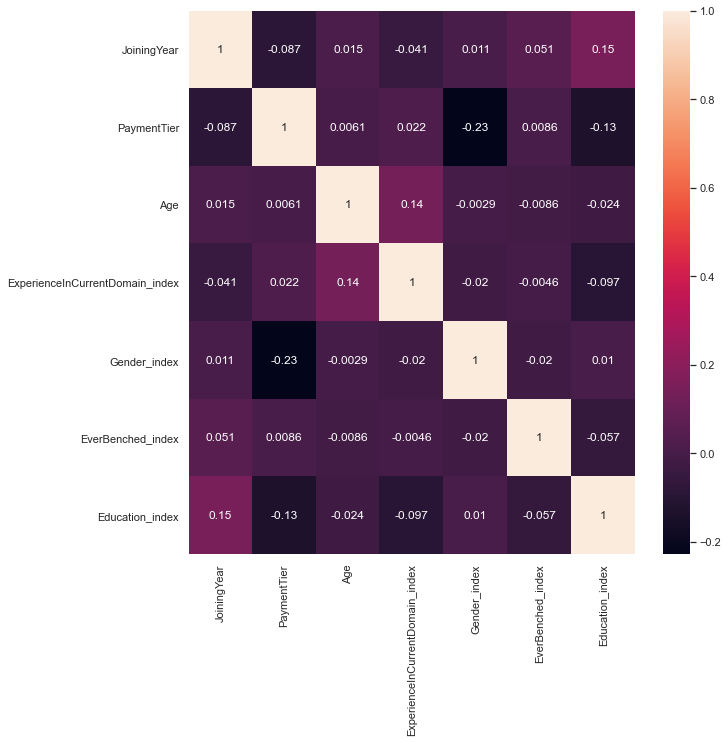

In [880]:
import matplotlib.pyplot as plt
import seaborn as sns
matriz_corr = df3_train.toPandas()[['JoiningYear', 'PaymentTier','Age','ExperienceInCurrentDomain_index', 'Gender_index', 'EverBenched_index', 'Education_index']].corr()
plt.figure(figsize=(10,10))
sns.heatmap(matriz_corr,xticklabels=matriz_corr.columns,yticklabels=matriz_corr.columns,annot=True)

**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">RANDOM FOREST</span> </center>**

<span style="font-family:Comic Sans MS; font-size:1em;color:black">Random Forest es un algoritmo robusto de aprendizaje automático que se puede usar para una variedad de tareas, incluidas la regresión y la clasificación. Es un método de conjunto, lo que significa que un modelo de bosque aleatorio se compone de una gran cantidad de pequeños árboles de decisión , llamados estimadores , cada uno de los cuales produce sus propias predicciones. El modelo de bosque aleatorio combina las predicciones de los estimadores para producir una predicción más precisa. </span>




<span style="font-family:Comic Sans MS; font-size:1em;color:black">En  nuestro caso vamos a usar un random forest de clasificación por nuestra columna a predecir</span>



In [881]:
from pyspark.ml.classification import RandomForestClassifier

<span style="font-family:Comic Sans MS; font-size:1em;color:black">Declaramos el random forest con las variables que va a tener en cuenta y con el número de árboles que en nuestro caso es 10</span>


In [1014]:
from pyspark.ml.classification import RandomForestClassifier
rf= RandomForestClassifier(featuresCol='features',labelCol='Leave_index', numTrees=10) 

rfModel = rf.fit(df3_train) # En el caso que quisieramos aplicar el modelo con la transformación de pca o normalizer, devemos de poner la variable correspondiente en train_xx



In [883]:
predictions = rfModel.transform(df3_test) # En el caso que quisieramos aplicar el modelo con la transformación de pca o normalizer, devemos de poner la variable correspondiente en test_xx
predictions.select('prediction','Leave_index','probability','features').show(5)


+----------+-----------+--------------------+--------------------+
|prediction|Leave_index|         probability|            features|
+----------+-----------+--------------------+--------------------+
|       0.0|        0.0|[0.82516008144432...|[2012.0,3.0,23.0,...|
|       0.0|        0.0|[0.82516008144432...|(7,[0,1,2],[2012....|
|       0.0|        0.0|[0.82516008144432...|(7,[0,1,2],[2012....|
|       0.0|        1.0|[0.82516008144432...|(7,[0,1,2],[2012....|
|       0.0|        1.0|[0.82516008144432...|(7,[0,1,2],[2012....|
+----------+-----------+--------------------+--------------------+
only showing top 5 rows



In [884]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [885]:
evaluator=BinaryClassificationEvaluator(labelCol='Leave_index',rawPredictionCol='prediction')

In [886]:
print('AraUnderROC:',evaluator.evaluate(predictions,{evaluator.metricName:'areaUnderROC'}))

AraUnderROC: 0.7450331125827815


In [887]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


rfModel = rf.fit(df3_train)
predictions_train = rfModel.transform(df3_train)

y_true = predictions_train.select(['Leave_index']).collect()
y_pred = predictions_train.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1])

              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87      2449
         1.0       0.93      0.49      0.64      1302

    accuracy                           0.81      3751
   macro avg       0.85      0.73      0.75      3751
weighted avg       0.83      0.81      0.79      3751



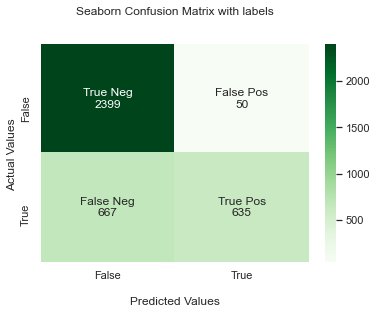

In [888]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Greens')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

<span style="font-family:Comic Sans MS; font-size:1em;color:black">Viendo el areaUnderROC de test, podemos comprobar que el RandomForest base de 20 árboles se está comportando mejor que el LogisticRegression de clasificación obteniendo un 73,60% frente al 67% que opteniamos con el modelo de regresión </span>



<span style="font-family:Comic Sans MS; font-size:1em;color:black">A continuación, parametros con los que se ha entrenado el modelo.</span>



In [889]:
rfModel.extractParamMap()

{Param(parent='RandomForestClassifier_0c6b80062e8a', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_0c6b80062e8a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_0c6b80062e8a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_0c6b80062e8a', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">Con la siguiente línea de código podemos ver la explicacion de cada parámetro del modelo.</span>

 

In [890]:
print(rfModel.explainParams())

bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the featur

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">Los modelos de árbol tambien se emplean para reducir las dimesiones como podemos ver a continuación:</span>




In [891]:
rfModel.featureImportances

SparseVector(7, {0: 0.5462, 1: 0.2165, 2: 0.0329, 3: 0.0126, 4: 0.0778, 5: 0.0183, 6: 0.0957})

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">Aqui podemos ver la "importancia" de cada una de las variables, podemos ver que ninguna variable es demasiado importante e excepción de la primera que si lo es, por lo que podriamos afinar el modelo de RandomForest quedandonos con las variable 0, 2 y 4 por ejemplo. Deberiamos volver a entrenar y evaluar el modelo con un nuevo vector features con esas variables.</span>





**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">MEJORA GRID</span> </center>**


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">
Como nuestro modelo no es del todo perfecto pasamos a realizar una mejora con el objetivo de optimizar este proceso, dicha mejora es un algoritmo que itera a través de la lista de valores de los parámetros, estima los modelos de manera independiente y escoje la mejor opción.</span>








In [892]:
import pyspark.ml.tuning as tune

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">


Especificamos a nuestro modelo la lista de parámetros sobre la que queremos iterar.

Para ello añadimos parámetros al Grid con "addGrid". El primer argumento de addGrid es el parámetro que queremos optimizar y el segundo son los posibles valores que puede tener.

Hacemos el "build" para construir el Grid</span>



In [893]:
import pyspark.ml.classification as cl
import pyspark.ml.tuning as tune

rf3=cl.RandomForestClassifier(labelCol='Leave_index')

grid = tune.ParamGridBuilder().addGrid(rf3.numTrees, [10,30]).build()


In [894]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [895]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='Leave_index')


In [896]:
cv = tune.CrossValidator(estimator=rf, estimatorParamMaps=grid, evaluator=evaluator)


In [897]:
cvModel = cv.fit(df3_train)


In [898]:


results = cvModel.transform(df3_test)

print(evaluator.evaluate(results, {evaluator.metricName: 'areaUnderROC'}))

0.8316202942352994


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">



¿Qué parámetros han sido los mejores para obtener estos resultados? </span>






In [899]:
df3_transformer = pipeline.fit(df3_train)

In [900]:
results = [
    (
        [
            {key.name: paramValue} 
            for key, paramValue 
            in zip(
                params.keys(), 
                params.values())
        ], metric
    ) 
    for params, metric 
    in zip(
        cvModel.getEstimatorParamMaps(), 
        cvModel.avgMetrics
    )
]

sorted(results, key=lambda el: el[1], reverse=True)[0]

([{'numTrees': 10}], 0.8271688351066326)

In [901]:
df3_transformer.stages

[StringIndexerModel: uid=StringIndexer_6a5c9c232d59, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_3647aa54a430, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_b2eae3521408, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_0415877b83e6, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_de9ba618e4ff, handleInvalid=error]

In [902]:
df3_transformer.explainParams()

''

In [903]:
cvModel.bestModel.explainParams()

"bootstrap: Whether bootstrap samples are used when building trees. (default: True)\ncacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)\ncheckpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)\nfeatureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the fe

In [904]:
print('Best Param (MaxDepth): ', cvModel.bestModel._java_obj.getMaxDepth())

Best Param (MaxDepth):  5


In [905]:
l=cvModel.params

In [906]:
cv.extractParamMap()

{Param(parent='CrossValidator_76f084c2c99a', name='collectSubModels', doc='Param for whether to collect a list of sub-models trained during tuning. If set to false, then only the single best sub-model will be available after fitting. If set to true, then all sub-models will be available. Warning: For large models, collecting all sub-models can cause OOMs on the Spark driver.'): False,
 Param(parent='CrossValidator_76f084c2c99a', name='parallelism', doc='the number of threads to use when running parallel algorithms (>= 1).'): 1,
 Param(parent='CrossValidator_76f084c2c99a', name='seed', doc='random seed.'): 3555959104600968043,
 Param(parent='CrossValidator_76f084c2c99a', name='numFolds', doc='number of folds for cross validation'): 3,
 Param(parent='CrossValidator_76f084c2c99a', name='foldCol', doc="Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with ra

In [907]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.param import Param, Params



# Learn a LogisticRegression model. This uses the parameters stored in lr.
model1 = rf.fit(df3_train)

# Since model1 is a Model (i.e., a transformer produced by an Estimator),
# we can view the parameters it used during fit().
# This prints the parameter (name: value) pairs, where names are unique IDs for this
# LogisticRegression instance.
print("Model 1 was fit using parameters: ")
print(model1.extractParamMap())

Model 1 was fit using parameters: 
{Param(parent='RandomForestClassifier_0c6b80062e8a', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True, Param(parent='RandomForestClassifier_0c6b80062e8a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False, Param(parent='RandomForestClassifier_0c6b80062e8a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10, Param(parent='RandomForestClassifier_0c6b80062e8a', name='featureSubsetStrategy', doc="The number of features to consider fo

In [908]:
m=rf.copy()

In [909]:
m.getMaxDepth()

5

In [910]:
m.extractParamMap()

{Param(parent='RandomForestClassifier_0c6b80062e8a', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_0c6b80062e8a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_0c6b80062e8a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_0c6b80062e8a', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [911]:
cv.explainParams()

"collectSubModels: Param for whether to collect a list of sub-models trained during tuning. If set to false, then only the single best sub-model will be available after fitting. If set to true, then all sub-models will be available. Warning: For large models, collecting all sub-models can cause OOMs on the Spark driver. (default: False)\nestimator: estimator to be cross-validated (current: RandomForestClassifier_0c6b80062e8a)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='RandomForestClassifier_ac30bc921222', name='numTrees', doc='Number of trees to train (>= 1).'): 10}, {Param(parent='RandomForestClassifier_ac30bc921222', name='numTrees', doc='Number of trees to train (>= 1).'): 30}])\nevaluator: evaluator used to select hyper-parameters that maximize the validator metric (current: BinaryClassificationEvaluator_6b8fd6c9191d)\nfoldCol: Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold 

In [912]:
bestPipeline = cvModel.bestModel

In [913]:
bestPipeline

RandomForestClassificationModel: uid=RandomForestClassifier_0c6b80062e8a, numTrees=10, numClasses=2, numFeatures=7

In [914]:
cvModel.avgMetrics

[0.8271688351066326, 0.8271688351066326]

In [915]:
trainingSummary = cvModel.bestModel.summary # Creamos una variable que es igual al nombre del modelo .bestModel y .summary
metrics(trainingSummary) 

Area under ROC: 0.8361024186805612
False positive rate by label:
label 0: 0.5122887864823349
label 1: 0.02041649652919559
True positive rate by label:
label 0: 0.9795835034708044
label 1: 0.4877112135176651
Precision by label:
label 0: 0.7824527071102414
label 1: 0.927007299270073
Recall by label:
label 0: 0.9795835034708044
label 1: 0.4877112135176651
F-measure by label:
label 0: 0.8699909338168632
label 1: 0.6391545042778057
Accuracy: 0.808850973073847
FPR: 0.34155625608537743
TPR: 0.808850973073847
F-measure: 0.789865892158678
Precision: 0.8326286812483648
Recall: 0.808850973073847


**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">REGRESIÓN LOGÍSTICA</span> </center>**

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">




Este modelo utiliza una función logit para calcular la probabilidad de que una observación pertenezca a una clase particular. Sin embargo al momento de escribir, PySpark ML solo nos admite problemas de clasificación binaria. </span>





In [916]:
def metrics(trainingSummary):

    # for multiclass, we can inspect metrics on a per-label basis

    print("Area under ROC: %s" % (trainingSummary.areaUnderROC))

    print("False positive rate by label:")
    for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print("True positive rate by label:")
    for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
        print("label %d: %s" % (i, rate))

    print("Precision by label:")
    for i, prec in enumerate(trainingSummary.precisionByLabel):
        print("label %d: %s" % (i, prec))

    print("Recall by label:")
    for i, rec in enumerate(trainingSummary.recallByLabel):
        print("label %d: %s" % (i, rec))

    print("F-measure by label:")
    for i, f in enumerate(trainingSummary.fMeasureByLabel()):
        print("label %d: %s" % (i, f))

    accuracy = trainingSummary.accuracy
    falsePositiveRate = trainingSummary.weightedFalsePositiveRate
    truePositiveRate = trainingSummary.weightedTruePositiveRate
    fMeasure = trainingSummary.weightedFMeasure()
    precision = trainingSummary.weightedPrecision
    recall = trainingSummary.weightedRecall
    print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
          % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

In [917]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='Leave_index')

In [918]:
logr_model=logr.fit(df3_train)

In [919]:
trainingSummary = logr_model.summary
metrics(trainingSummary)

Area under ROC: 0.708842412872367
False positive rate by label:
label 0: 0.6505376344086021
label 1: 0.13434054716210697
True positive rate by label:
label 0: 0.865659452837893
label 1: 0.34946236559139787
Precision by label:
label 0: 0.7145264577013819
label 1: 0.5803571428571429
Recall by label:
label 0: 0.865659452837893
label 1: 0.34946236559139787
F-measure by label:
label 0: 0.7828655834564255
label 1: 0.436241610738255
Accuracy: 0.6864836043721674
FPR: 0.47136178594287653
TPR: 0.6864836043721675
F-measure: 0.6625498243311102
Precision: 0.6679552905653651
Recall: 0.6864836043721675


In [920]:
logr_model.extractParamMap()

{Param(parent='LogisticRegression_7f16cd19c9a5', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_7f16cd19c9a5', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_7f16cd19c9a5', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_7f16cd19c9a5', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_7f16cd19c9a5', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_7f16cd19c9a5', name='labelCol', doc='label column name.'): 'Leave_index',
 Param(parent='LogisticRegression_7f16cd19c9a5', name='maxBlockSizeInMB', doc='maximum memory in MB

In [921]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = logr_model.transform(df3_test)

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">



Evaluamos el modelo </span>







In [922]:
evaluator = BinaryClassificationEvaluator(labelCol="Leave_index", rawPredictionCol="rawPrediction")
print(str(evaluator.getMetricName()) + ' en test: ' + str(evaluator.evaluate(predictions)))

areaUnderROC en test: 0.6775912262767243


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">



Nuestra área bajo la cruva ROC del modelo de Regresión lineal de clasificación es del 67,75%  </span>


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">


Ahora aplicamos un Logistic Regresion Base Model pero en este caso con las variables normalizadas y mostramos las metricas anteriores  </span>




 <span style="font-family:Comic Sans MS; font-size:1em;color:black">


Para ello necesito normalizar el train y test primero ya que posteriormente cuando realice el summary lo necesitaré  </span>



 <span style="font-family:Comic Sans MS; font-size:1em;color:black">

Procedemos a la transformación "normalizer" la cual aplicamos a nuestro conjunto de train (entrenamiento) y test, esta transformacion se debe de aplicar a los dos conjuntos debido a que si realizamos un algoritmo con esta transoformacion debemos de tener tanto el train como el test normalizados, esos los tenemos a continuacion. </span>




In [923]:
from pyspark.ml.feature import Normalizer
normalizer = Normalizer(inputCol="features", outputCol="normalizer_features", p=1.0)
train_normalizer = normalizer.transform(df3_train)
test_normalizer = normalizer.transform(df3_test)

In [924]:
logr1 = LogisticRegression(labelCol='Leave_index', featuresCol="normalizer_features") # Creamos el mismo modelo, un lr LogisticReresion, la labelCol es la raceposition pero el featuresCol deesmo poner nuestra normalizer_features 

logr1_model_normalizer = logr1.fit(train_normalizer)

# Summary
trainingSummary = logr1_model_normalizer.summary
metrics(trainingSummary)

Area under ROC: 0.6888082160247229
False positive rate by label:
label 0: 0.6781874039938556
label 1: 0.10902409146590446
True positive rate by label:
label 0: 0.8909759085340956
label 1: 0.32181259600614437
Precision by label:
label 0: 0.7119086460032626
label 1: 0.6107871720116618
Recall by label:
label 0: 0.8909759085340956
label 1: 0.32181259600614437
F-measure by label:
label 0: 0.7914399709829525
label 1: 0.42152917505030174
Accuracy: 0.6934150893095175
FPR: 0.4806265847692775
TPR: 0.6934150893095175
F-measure: 0.6630411823121151
Precision: 0.676808630237583
Recall: 0.6934150893095175


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">

Con el train vemos como el modelo tiene un área debajo de la curva de ROC de un 68,80% por lo que ha aumentado entorno a un 1% respecto a aplicar las variables sin normalizar </span>




In [925]:
predictions = logr1_model_normalizer.transform(test_normalizer)

# Evaluamos el modelo de nuevo
evaluator = BinaryClassificationEvaluator(labelCol="Leave_index", rawPredictionCol="rawPrediction")
print(str(evaluator.getMetricName()) + ' en test: ' + str(evaluator.evaluate(predictions)))

areaUnderROC en test: 0.6353171252055653


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">

Nuestra área bajo la cruva ROC del modelo de Regresión lineal de clasificación  es del 67,75% bajo las predicciones, hemos perdido un 4% respecto a aplicar las variables sin normalizar. Ganamos en el train pero en test no estamos ganando, es una mala señal, esta teniendo overfitting, sobreajuste.</span>







**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">PCA</span> </center>**

In [926]:
pca = PCA(k=4, inputCol="features", outputCol='pca_features')
model_pca = pca.fit(df3_train)
train_pca = model_pca.transform(df3_train)


In [927]:
test_pca = model_pca.transform(df3_test)


In [928]:
logr2 = LogisticRegression(labelCol="Leave_index", featuresCol="pca_features")

# Entrenamos el modelo con train_pca
logr2_model_pca = logr2.fit(train_pca)

#Summary
trainingSummary = logr2_model_pca.summary
metrics(trainingSummary)

Area under ROC: 0.7010976297419745
False positive rate by label:
label 0: 0.7450076804915514
label 1: 0.14250714577378523
True positive rate by label:
label 0: 0.8574928542262148
label 1: 0.25499231950844853
Precision by label:
label 0: 0.6840390879478827
label 1: 0.48751835535976507
Recall by label:
label 0: 0.8574928542262148
label 1: 0.25499231950844853
F-measure by label:
label 0: 0.7610074288820439
label 1: 0.33484619263741805
Accuracy: 0.6483604372167422
FPR: 0.5358752634820788
TPR: 0.6483604372167422
F-measure: 0.6130836939872151
Precision: 0.6158252799420898
Recall: 0.6483604372167422


In [929]:
predictions = logr2_model_pca.transform(test_pca)

# Evaluamos el modelo de nuevo 
evaluator = BinaryClassificationEvaluator(labelCol="Leave_index", rawPredictionCol="rawPrediction")
print(str(evaluator.getMetricName()) + ' en test: ' + str(evaluator.evaluate(predictions)))

areaUnderROC en test: 0.7021256500288905


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">
Con 5 variables nuestra área under ROC era de70,21% y con 3 es 63,53%; estamos perdiendo un 0,07% de precision reduciendo 2. Es una elección entre la precisión que estamos dispuestos a perder, las variables que estamos dispuestos a meter y el tiempo de ejecución.</span>





**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">STANDARIZATION</span> </center>**


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">
La estandarización de variables continuas ayuda no solo a comprender mejor las relaciones entre las características, sino que también ayuda a la eficiencia computacional.</span>




In [930]:
from pyspark.ml. feature import StandardScaler
scaler=StandardScaler(inputCol="features",outputCol="scaledFeatures",withStd=True,withMean=False)

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">

Estandarizamos la columna de features</span>




In [931]:
scaler_model=scaler.fit(df3_train)
scaled_training_data=scaler_model.transform(df3_train)
scaled_test_data=scaler_model.transform(df3_test)

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">



Volvemos a hacer el modelo y lo ejecutamos con los nuevos datos</span>


In [932]:
scaled_lr=LogisticRegression(labelCol='Leave_index')
scaled_lr_model = scaled_lr.fit(scaled_training_data)
scaled_predictions=scaled_lr_model.transform(scaled_test_data)

 <span style="font-family:Comic Sans MS; font-size:1em;color:black">



Evaluamos el modelo con el método de BinaryClassification</span>



In [933]:
scaled_evaluator= BinaryClassificationEvaluator(labelCol='Leave_index')
print('AreaUnderROC',scaled_evaluator.evaluate(scaled_predictions,{scaled_evaluator.metricName: 'areaUnderROC'}))


AreaUnderROC 0.6775912262767243


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">


Después de dicha mejora la precisión de nuestro modelo ha aumentado hasta un 67,75% en el AreaUnderROC</span>




**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">DISCRETIZAR</span> </center>**


 <span style="font-family:Comic Sans MS; font-size:1em;color:black">

Como tenemos la variable edad que es una variable continua en nuestro dataset, es difícil para nuestro modelo sacar alguna conclusión de la relación entre la misma y la salida.

Es por eso que vamos a realizar un ejemplo de discretización. Creamos un conjunto de datos de ejemplo y lo metemos en un DataFrame</span>




In [934]:

from pyspark.ml.feature import QuantileDiscretizer

discretizer = QuantileDiscretizer(numBuckets=10, inputCol="Age", outputCol="Age_dis")

result = discretizer.fit(df3).transform(df3)
result.show()

+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+-------+
|JoiningYear|     City|PaymentTier|Age|Gender_index|EverBenched_index|Education_index|ExperienceInCurrentDomain_index|Leave_index|            features|Age_dis|
+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+-------+
|       2017|Bangalore|          3| 34|         0.0|              0.0|            0.0|                            5.0|        0.0|[2017.0,3.0,34.0,...|    6.0|
|       2013|     Pune|          1| 28|         1.0|              0.0|            0.0|                            3.0|        1.0|[2013.0,1.0,28.0,...|    4.0|
|       2014|New Delhi|          3| 38|         1.0|              0.0|            0.0|                            0.0|        0.0|[2014.0,3.0,38.0,...|    7.0|
|       2016|Bangalore|          3| 27| 

<span style="font-family:Comic Sans MS; font-size:1em;color:black">


Volvemos a ejecutar nuestro modelo una vez hemos cambiado nuestra variable edad de tipo continua a discreta</span>


In [935]:
import pyspark.ml.classification as cl

classifier=cl.RandomForestClassifier(
   numTrees=20,
   maxDepth=10, 
    labelCol='Leave_index')


<span style="font-family:Comic Sans MS; font-size:1em;color:black">



Creamos el pipeline</span>



In [936]:

from pyspark.ml import Pipeline
pipeline_estand = Pipeline(stages=[ discretizer,classifier])

In [937]:
model_estand = pipeline_estand.fit(df3_train)

In [938]:
test_model_estand = model_estand.transform(df3_test)

In [939]:
test_model_estand.take(1)

[Row(JoiningYear=2012, City='Bangalore', PaymentTier=3, Age=23, Gender_index=0.0, EverBenched_index=0.0, Education_index=0.0, ExperienceInCurrentDomain_index=4.0, Leave_index=0.0, features=DenseVector([2012.0, 3.0, 23.0, 4.0, 0.0, 0.0, 0.0]), Age_dis=0.0, rawPrediction=DenseVector([17.4147, 2.5853]), probability=DenseVector([0.8707, 0.1293]), prediction=0.0)]


<span style="font-family:Comic Sans MS; font-size:1em;color:black">




Evaluamos el modelo tras estandarizar las variables categoricas</span>




In [940]:
# evaluamos el modelo tras estandarizar las variables categoricas
import pyspark.ml.evaluation as ev
evaluator_estand = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='Leave_index')

print(evaluator_estand.evaluate(test_model_estand, {evaluator_estand.metricName: 'areaUnderROC'}))

0.8383011467176323



<span style="font-family:Comic Sans MS; font-size:1em;color:black">





Nuestra precisión ha aumentado en un 10% en relación a nuestro primer modelo </span>




**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">PCA</span> </center>**



<span style="font-family:Comic Sans MS; font-size:1em;color:black">






Principal Component Analysis (PCA) es un método estadístico que permite simplificar la complejidad de espacios muestrales con muchas dimensiones a la vez que conserva su información. </span>





In [941]:
from pyspark.ml. feature import PCA
pca = PCA(k=4, inputCol="features", outputCol=" pcafeatures")
pca_model=pca.fit(df3_train)
pca_training_data=pca_model.transform(df3_train)
pca_test_data=pca_model.transform(df3_test)



In [942]:
pca_lr = LogisticRegression(labelCol='Leave_index')
pca_lr_model=pca_lr.fit(pca_training_data)
pca_predictions=pca_lr_model.transform(pca_test_data)

In [943]:

pca_evaluator=BinaryClassificationEvaluator(labelCol="Leave_index")
print("AreaUnderROC:",pca_evaluator.evaluate(pca_predictions,{pca_evaluator.metricName:"areaUnderROC"}))
print("AreaUnderPR:",pca_evaluator.evaluate(pca_predictions,{pca_evaluator.metricName:'areaUnderPR'}))

AreaUnderROC: 0.6775912262767243
AreaUnderPR: 0.4880219223059582


<span style="font-family:Comic Sans MS; font-size:1em;color:black">





Lo hemos implementado en el modelo de regresión logística para ver si así mejorabamos de forma más considerable nuestro modelo menos preciso y después de aplicar dicho método hemos mejorado un 8% nuestro modelo en comparación a su primero ejecución </span>
 

**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">CROSS VALIDATOR</span> </center>**



<span style="font-family:Comic Sans MS; font-size:1em;color:black">



La validación cruzada o cross-validation es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba y de esta manera evitar el overfitting</span>
 



In [944]:
lr = LogisticRegression(labelCol='Leave_index')
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Creamos ParamGrid para Cross Validation
paramGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0])
            .addGrid(lr.maxIter, [1, 5, 10, 20])
            .build())
# Creamos 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Ejecutamos cross validations
cvModel = cv.fit(df3_train)

cvModel.avgMetrics

[0.7078232423687942,
 0.7041549226178818,
 0.7041383581979614,
 0.7041383581979614,
 0.7078232423687942,
 0.7053196936231912,
 0.7053210304078891,
 0.7053210304078891,
 0.7078232423687942,
 0.7071351915522303,
 0.7071610903641614,
 0.7071610903641614,
 0.7078232423687942,
 0.7072510282595754,
 0.7073300410777501,
 0.7073300410777501]

<span style="font-family:Comic Sans MS; font-size:1em;color:black">




Ahora queremos selecionar el mejor modelo, lo cual lo podemos realizar de la siguiente forma:</span>
 


<span style="font-family:Comic Sans MS; font-size:1em;color:black">



Creamos una variable que es igual al nombre del modelo .bestModel y .summary</span>
 


In [945]:
trainingSummary = cvModel.bestModel.summary 

In [946]:

metrics(trainingSummary)

Area under ROC: 0.710911974479066
False positive rate by label:
label 0: 0.521505376344086
label 1: 0.19436504695794202
True positive rate by label:
label 0: 0.805634953042058
label 1: 0.478494623655914
Precision by label:
label 0: 0.7439668174962293
label 1: 0.5668789808917197
Recall by label:
label 0: 0.805634953042058
label 1: 0.478494623655914
F-measure by label:
label 0: 0.7735738090570476
label 1: 0.5189504373177842
Accuracy: 0.6920821114369502
FPR: 0.40795253473897813
TPR: 0.6920821114369502
F-measure: 0.6851921428335017
Precision: 0.6824983122285483
Recall: 0.6920821114369502


<span style="font-family:Comic Sans MS; font-size:1em;color:black">



Podemos observar que el mejor modelo que hemos creado mediane el algoritmo de LR, nos genera una área bajo la curva ROC del 70,09% en training

Para poder conocer los parámetros con los cuales hemos creado/realizado el mejor modelo, creamos la siguiente sentencia:</span>
 


In [947]:
cvModel.bestModel.extractParamMap() 

{Param(parent='LogisticRegression_612e820b33c7', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_612e820b33c7', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_612e820b33c7', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_612e820b33c7', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_612e820b33c7', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_612e820b33c7', name='labelCol', doc='label column name.'): 'Leave_index',
 Param(parent='LogisticRegression_612e820b33c7', name='maxBlockSizeInMB', doc='maximum memory in MB

In [987]:
predictions = cvModel.bestModel.transform(df3_test)

# Evaluamos el modelo
evaluator = BinaryClassificationEvaluator(labelCol="Leave_index", rawPredictionCol="rawPrediction")
print(str(evaluator.getMetricName()) + ' en test: ' + str(evaluator.evaluate(predictions)))

areaUnderROC en test: 0.6810080448019913


<span style="font-family:Comic Sans MS; font-size:1em;color:black">

El área under ROC del mejor modelo es del 68,81%, este ha sido el mejor resultado que hemos obtenido gracias al paramGrid, que es un resultado ligeramente mejor que el que hemos obtenido anteriormente con este mismo algoritmo, que era de 67%</span>
 




In [949]:
import sklearn 
from pyspark.ml.classification import RandomForestClassifier


lrModel = lr.fit(df3_train)
predictions_train = lrModel.transform(df3_train)

y_true = predictions_train.select(['Leave_index']).collect()
y_pred = predictions_train.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))
cnf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1])

              precision    recall  f1-score   support

         0.0       0.71      0.87      0.78      2449
         1.0       0.58      0.35      0.44      1302

    accuracy                           0.69      3751
   macro avg       0.65      0.61      0.61      3751
weighted avg       0.67      0.69      0.66      3751



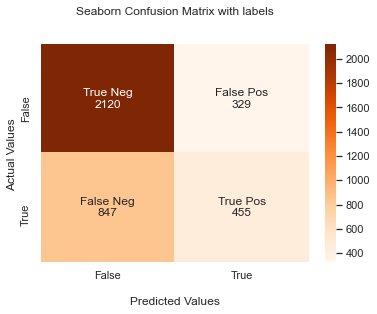

In [950]:
import seaborn as sns

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cnf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Oranges')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">GRADIENT BOOSTING</span> </center>**



<span style="font-family:Comic Sans MS; font-size:1em;color:black">
Gradient boosting o Potenciación del gradiente, es una técnica de aprendizaje automático utilizado para el análisis de la regresión y para problemas de clasificación estadística, el cual produce un modelo predictivo en forma de un conjunto de modelos de predicción débiles, típicamente árboles de decisión.</span>
 




In [951]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="Leave_index", featuresCol="features")

gbtModel = gbt.fit(df3_train)

In [952]:
predictions = gbtModel.transform(df3_test)

# Evaluamos
evaluator = BinaryClassificationEvaluator(labelCol="Leave_index", rawPredictionCol="rawPrediction")
print(str(evaluator.getMetricName()) + ' en test: ' + str(evaluator.evaluate(predictions)))

areaUnderROC en test: 0.8391817414107294


<span style="font-family:Comic Sans MS; font-size:1em;color:black">

Tras realizar el algoritmo mencionado anteriormente optenemos que nuestro modelo tendría una precisión de un 83% </span>
 




In [953]:
gbtModel.extractParamMap() 

{Param(parent='GBTClassifier_7eec16fd8e33', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_7eec16fd8e33', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_7eec16fd8e33', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r

In [954]:
print(gbtModel.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

<span style="font-family:Comic Sans MS; font-size:1em;color:black">
En este modelo tambien podemos observar la importancia de las varibales como en el RF de a siguiente manera: </span>
 






In [955]:
gbtModel.featureImportances

SparseVector(7, {0: 0.3491, 1: 0.2216, 2: 0.0762, 3: 0.1103, 4: 0.0627, 5: 0.0313, 6: 0.1489})

<span style="font-family:Comic Sans MS; font-size:1em;color:black">

Aqui en el GB, podemos observar que la importancia de las variables no son tan diferentes al del RF, ya que la nº 0 también destaca sobre las demás pero en este algoritmo en menor magnitud  </span>
 





In [998]:
from pyspark.ml. feature import PCA
pca = PCA(k=5, inputCol="features", outputCol="pcafeatures")
pca_model=pca.fit(df3_train)
pca_training_data=pca_model.transform(df3_train)
pca_test_data=pca_model.transform(df3_test)

pca_gb =GBTClassifier(labelCol="Leave_index", featuresCol="pcafeatures")
pca_gb_model=pca_gb.fit(pca_training_data)
pca_predictions=pca_gb_model.transform(pca_test_data)



In [999]:
# evaluamos el modelo llevado a cabo
import pyspark.ml.evaluation as ev

pca_evaluator = ev.BinaryClassificationEvaluator(
    rawPredictionCol='probability', 
    labelCol='Leave_index')

print(pca_evaluator.evaluate(pca_predictions, {pca_evaluator.metricName: 'areaUnderROC'}))

0.8384400417796349


**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">EXTRACCIÓN DE CARACTERÍSTICAS</span> </center>**


<span style="font-family:Comic Sans MS; font-size:1em;color:black">
Para la extracción de características vamos a usar el método ChiSqSelector que se utiliza para seleccionar características (reducción de dimensionalidad) mediante la prueba de chi-cuadrado  </span>
 





In [1000]:
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors


chi =ChiSqSelector(numTopFeatures=4, featuresCol="features", outputCol="features_chi", labelCol="Leave_index")

chi_model = chi.fit(df3)
df4=chi_model.transform(df3)



Las siguientes celda muestra las 4 características más significativas de nuestro dataset

In [1001]:
chi_model.selectedFeatures

[0, 1, 4, 6]

In [1003]:
variables =['JoiningYear',
                    'PaymentTier',
                    'Age',
                    'ExperienceInCurrentDomain_index',
                     'Gender_index',
                     'EverBenched_index',
                     'Education_index',
                     ]

En la siguiente celda mostramos el nombre concreto de las variables que anteriormente habíamos dicho que eran las más características

In [1004]:
string_colums = [variables[x] for x in chi_model.selectedFeatures]
string_colums

['JoiningYear', 'PaymentTier', 'Gender_index', 'Education_index']

In [1002]:
df4.show()

+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+--------------------+
|JoiningYear|     City|PaymentTier|Age|Gender_index|EverBenched_index|Education_index|ExperienceInCurrentDomain_index|Leave_index|            features|        features_chi|
+-----------+---------+-----------+---+------------+-----------------+---------------+-------------------------------+-----------+--------------------+--------------------+
|       2017|Bangalore|          3| 34|         0.0|              0.0|            0.0|                            5.0|        0.0|[2017.0,3.0,34.0,...|[2017.0,3.0,0.0,0.0]|
|       2013|     Pune|          1| 28|         1.0|              0.0|            0.0|                            3.0|        1.0|[2013.0,1.0,28.0,...|[2013.0,1.0,1.0,0.0]|
|       2014|New Delhi|          3| 38|         1.0|              0.0|            0.0|                            0.0|        0.0|[2014

In [1005]:
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
model = pca.fit(df3)
model.transform(df3).collect()[0].pca_features

DenseVector([45.4194, 1993.3755])

**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">BALANCEO</span> </center>**

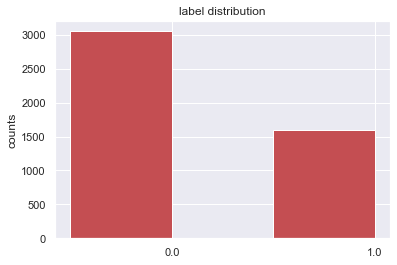

In [962]:
responses = df3.groupBy('Leave_index').count().collect()
categories = [i[0] for i in responses]
counts = [i[1] for i in responses]
ind = np.array(range(len(categories)))
width = 0.5
plt.bar(ind, counts, width=width, color='r')
plt.ylabel('counts')
plt.title('label distribution')
plt.xticks(ind + width/2., categories)
plt.show()

<span style="font-family:Comic Sans MS; font-size:1em;color:black">
Como podemos observar en la anterior gráfica nuestros datos no se encuentran balanceados, viendo así como el número de 0 es mucho mayor al número de 1, lo cual es bastante importante a la hora de entrenar nuestro modelo porque los resultados obtenidos no son del todo precisos </span>
 





**<center><span style="font-family:Cooper Black; font-size:2em;color:blue">CURVA DE ROC</span> </center>**

In [963]:
fit = gbt.fit(df3_train)
transformed1 = fit.transform(df3_test)

In [964]:
fit = rf.fit(df3_train)
transformed2 = fit.transform(df3_test)

In [965]:
fit = logr.fit(df3_train)
transformed3 = fit.transform(df3_test)

In [966]:

from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed1.select(['rawPrediction', 'Leave_index'])

## prepare score-label set
results_collect = results.collect()
results_list1 = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]


In [967]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed2.select(['rawPrediction', 'Leave_index'])

## prepare score-label set
results_collect = results.collect()
results_list2 = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]


In [968]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
results = transformed3.select(['rawPrediction', 'Leave_index'])

## prepare score-label set
results_collect = results.collect()
results_list3 = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]


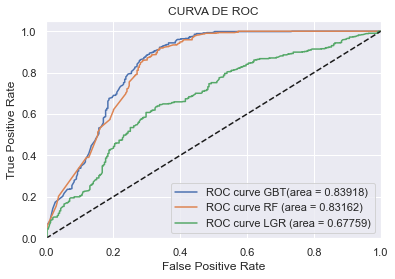

In [969]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

y_test1 = [i[1] for i in results_list1]
y_score1 = [i[0] for i in results_list1]
y_test2 = [i[1] for i in results_list2]
y_score2 = [i[0] for i in results_list2]
y_test3 = [i[1] for i in results_list3]
y_score3 = [i[0] for i in results_list3]

fpr1, tpr1, _ = roc_curve(y_test1, y_score1)
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _ = roc_curve(y_test2, y_score2)
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, _ = roc_curve(y_test3, y_score3)
roc_auc3 = auc(fpr3, tpr3)


%matplotlib inline
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve GBT(area = %0.5f)' % roc_auc1)
plt.plot(fpr2, tpr2, label='ROC curve RF (area = %0.5f)' % roc_auc2)
plt.plot(fpr3, tpr3, label='ROC curve LGR (area = %0.5f)' % roc_auc3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CURVA DE ROC')
plt.legend(loc="lower right")
plt.show()

<span style="font-family:Comic Sans MS; font-size:1em;color:black">
    
CONCLUSIONES

Como se puede observar en la gráfica anterior los dos mejores modelos son el de Gradient Boosting y el de Random Forest donde no hay casi diferencia entre ambos, son practicamente iguales tanto en especifidad como en sensibilidad.

    
    
REGRESIÓN LOGISTICA
    
Nuestro modelo de Regresión logística alcanza una precisión óptima tras la estandarización de variables y el PCA, en la cual aplicamos una k igual 4. Escogemos este valor debido a la extracción de variables, con la que vemos que las variables más significativas de nuestro Dataset son el año de incorporación a la empresa, el sueldo del empleado, el género y el nivel de estudio. La precisión obtenida es del 70.21%, sin embargo para asegurarnos de que no exista overfitting hemos decidido realizar una validación cruzada, reduciendo la precisió a un 68.10%


RANDOM FOREST
    
 - El Random Forest presenta un areaUnderROC = 83.83% , es un buen resultado, comparado con el obtenido en la regresión logística. Este es uno de los principales algoritmos más empleados, por lo que creemos que si modificamos el número de árboles empleado (en este resultado hemos empleado el número base que son 20) entre 50 y 100 podemos llegar a obtener los mismos resultados o mejores. 
Además, este algorimo nos permite ver la importancia de las feature, lo cual se asemeja bastante a la informacion que podemos llegar a tener mediante el PCA

GRADIENT BOOSTING
    
 - El resultado del algoritmo es areaUnderROC = 83.845% , este algoritmo también presenta la misma funcionalidad que el RF, sin embargo es más preciso, ya que no basa el resultado final en la media de los resultados de cada árbol, sino que también modifica el resultado de cada árbol individual mediante la reducción de gradiente.
</span>
 


